In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

import sys

from importlib import reload

import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)s | %(name)s | %(levelname)s : %(message)s',
    level=logging.INFO,
    stream=sys.stdout
)

logger = logging.getLogger('hysped')
logger.setLevel(logging.DEBUG)

import contextily as ctx
import geocube
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import re
import seaborn as sns
import shapely
import tensorflow as tf
import zipfile

import wandb
wandb.login()

from functools import partial
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from IPython.display import JSON, HTML
from keras.utils.np_utils import to_categorical
from matplotlib.colors import to_rgba
from shapely.geometry import box, mapping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tqdm.notebook import trange, tqdm
from wandb.keras import WandbMetricsLogger, WandbEvalCallback


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # configure utilization of GPUs
    try:
        for gpu in gpus:
            # memory growth setting
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=256)]
            )
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        module_logger.error(e)


# Make numpy values easier to read.
np.set_printoptions(precision=6, suppress=True)

%matplotlib inline

wandb: Currently logged in as: stevo (hysped). Use `wandb login --relogin` to force relogin


In [2]:
cfg = dict(
    crs = 'EPSG:5514',
    figsize = (12,12),
    data_dir = os.path.join('..', 'data'),
    data = 'Sverepec_spolu.zip',
    data_sampling = True
)
display(JSON(cfg))

<IPython.core.display.JSON object>

In [3]:
def split_df(df:pd.DataFrame, split:float=0.7) -> pd.DataFrame:
    rows = df.shape[0]
    at = int(split * rows)
    return df[:at], df[at:]

def nsplit_df(df:pd.DataFrame, splits:[float]=[0.7]) -> pd.DataFrame:
    rows = df.shape[0]
    df_splits = []
    beg = 0
    for split in splits:
        at = int(split * rows)
        df_splits.append(df[beg:at])
        beg = at
    df_splits.append(df[beg:])
    return df_splits

def predict_model(m, X, Y, label_encoder):
    Y_pred = m.predict(X)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_pred = label_encoder.inverse_transform(Y_pred)
    Y_pred = pd.DataFrame(Y_pred, columns=['Y_pred'])
    return Y_pred

def print_cm(ax, cm, labels, title='Confusion Matrix'):
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        ax=ax,
        cmap='Blues',
        # square=True,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=1,
        # annot_kws={'size': 12}
    )

    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
def print_hist(df: pd.DataFrame, col_name='DRUH_DR', stat='count', title=None):
    g = sns.histplot(df[col_name], stat=stat)
    g.xaxis.set_major_locator(mticker.FixedLocator(g.get_xticks()))
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    if title != None:
        plt.title(title)
    plt.tight_layout()
    plt.show()

# Preprocess data

## Load

,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,b7_12_10_2,b8_12_10_2,b9_12_10_2,b10_12_10_,...,b178_12_10,b179_12_10,b180_12_10,b181_12_10,b182_12_10,b183_12_10,b184_12_10,b185_12_10,b186_12_10,DRUH_DR
0,0.002312,0.002194,0.002344,0.002613,0.002497,0.002717,0.002706,0.002898,0.002586,0.003052,...,0.046049,0.043585,0.043107,0.045929,0.051554,0.052172,0.054623,0.054570,0.054656,CR
1,0.002277,0.002337,0.002361,0.002488,0.002334,0.002713,0.002796,0.002779,0.002748,0.003034,...,0.042515,0.040856,0.039885,0.043333,0.047781,0.048725,0.047153,0.050167,0.052182,CR
2,0.002243,0.002479,0.002402,0.002322,0.002627,0.002943,0.002809,0.002854,0.002725,0.003096,...,0.044127,0.042798,0.042160,0.042548,0.048506,0.049747,0.050620,0.051325,0.054525,CR
3,0.001883,0.002045,0.002057,0.001970,0.002191,0.002052,0.002102,0.001991,0.001920,0.002308,...,0.035453,0.032728,0.033034,0.034035,0.037514,0.040421,0.040852,0.040839,0.042109,CR
4,0.002193,0.001915,0.002164,0.002090,0.002031,0.002108,0.002084,0.002123,0.001950,0.002291,...,0.026016,0.025324,0.024879,0.026462,0.029662,0.030414,0.031456,0.031279,0.032800,CR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33715,0.002469,0.002863,0.003135,0.003027,0.003056,0.003230,0.003328,0.003523,0.003396,0.003746,...,0.029615,0.028368,0.026700,0.027315,0.031556,0.033276,0.032708,0.033844,0.033287,BR
33716,0.001235,0.000966,0.000953,0.001050,0.000891,0.001143,0.000930,0.001075,0.000944,0.001074,...,0.006762,0.007508,0.006300,0.007368,0.007559,0.008111,0.009299,0.008149,0.008633,BR
33717,0.001709,0.001565,0.001225,0.001534,0.001722,0.002060,0.001738,0.001615,0.001751,0.002011,...,0.026855,0.025384,0.025439,0.025496,0.027390,0.029442,0.033317,0.032171,0.032443,BR
33718,0.001823,0.001716,0.001534,0.001772,0.001997,0.002358,0.002048,0.001988,0.001989,0.002377,...,0.029279,0.027654,0.027549,0.027910,0.030475,0.032133,0.035963,0.035193,0.035305,BR


,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,b7_12_10_2,b8_12_10_2,b9_12_10_2,b10_12_10_,...,b177_12_10,b178_12_10,b179_12_10,b180_12_10,b181_12_10,b182_12_10,b183_12_10,b184_12_10,b185_12_10,b186_12_10
count,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,...,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000
mean,0.002247,0.002304,0.002430,0.002565,0.002615,0.002691,0.002687,0.002638,0.002487,0.002943,...,0.024226,0.029662,0.028207,0.027531,0.029403,0.031902,0.033641,0.034560,0.035118,0.035639
std,0.000882,0.000927,0.000999,0.001066,0.001103,0.001149,0.001161,0.001158,0.001098,0.001331,...,0.014980,0.018450,0.017572,0.017085,0.018232,0.019761,0.020832,0.021402,0.021732,0.022028
min,0.000369,0.000332,0.000345,0.000441,0.000444,0.000410,0.000456,0.000441,0.000372,0.000461,...,0.000646,0.000580,0.000697,0.000635,0.000652,0.000638,0.000869,0.000687,0.001013,0.000771
25%,0.001588,0.001611,0.001675,0.001761,0.001775,0.001806,0.001789,0.001735,0.001632,0.001898,...,0.011574,0.014084,0.013299,0.013060,0.013952,0.015179,0.016041,0.016421,0.016770,0.016946
50%,0.002207,0.002261,0.002381,0.002520,0.002568,0.002650,0.002657,0.002603,0.002462,0.002909,...,0.022414,0.027441,0.026038,0.025482,0.027207,0.029539,0.031093,0.031970,0.032546,0.033004
75%,0.002824,0.002898,0.003079,0.003261,0.003335,0.003446,0.003457,0.003407,0.003230,0.003837,...,0.036040,0.044239,0.042118,0.041040,0.043859,0.047575,0.050114,0.051479,0.052331,0.053096
max,0.005978,0.006260,0.006729,0.007038,0.007524,0.007449,0.007360,0.007368,0.006909,0.008184,...,0.066931,0.082097,0.078523,0.076033,0.080653,0.085611,0.091917,0.093709,0.094180,0.095604


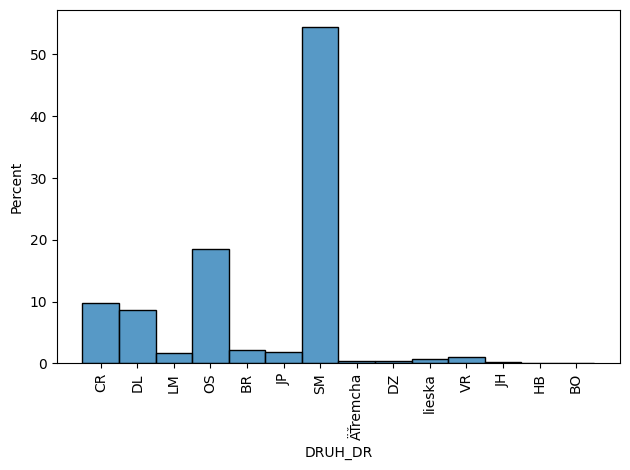

In [4]:
filename = os.path.join(cfg['data_dir'], cfg['data'])
df = pd.read_csv(filename)

display(HTML('<h2>Data preview:</h2>'))
display(df)
display(HTML('<hr>'))
display(HTML('<h2>Data statistics:</h2>'))
display(df.describe())

print_hist(df, stat='percent')

## data sampling

In [5]:
def sample_data(df):
    # remove duplicates
    mask = df.duplicated(keep='first')
    df = df[~mask].copy(deep=True)
    
    # classes counts
    df_hist = df.DRUH_DR.groupby(df.DRUH_DR).count().sort_values(ascending=False)
    # print('%s\n' % df_hist)

    # select the most frequent classes
    selected_classes = df_hist[df_hist > 2500].index.values
    # print('selected_classes: %s\n' % selected_classes)

    # set the rest of the classes to OTHER
    mask = df.DRUH_DR.isin(selected_classes)
    df.loc[~mask,df.DRUH_DR.name] = 'OTHER'
    # print_hist(df)

    # the number of samples for the least frequent class of the most frequent classes
    min_count = df.DRUH_DR.groupby(df.DRUH_DR).count().min()
    # print('min count: %d' % min_count)

    # sample data per class
    df_sampled = pd.DataFrame()
    for class_name in df.DRUH_DR.unique():
        df_class = df[df.DRUH_DR.str.match(class_name)].sample(n=min_count, axis=0)
        df_sampled = pd.concat([df_sampled, df_class])

    return df_sampled

def plot_band_characteristics(df):
    g = sns.FacetGrid(df, col="DRUH_DR", col_wrap=6)
    # plot only features starting with 'b0, b1, ..., b9'
    for col in enumerate(df.columns[df.columns.to_series().str.match(r'^b\d+.*')]):
        gg = g.map(sns.kdeplot, col[1], label=col[1], warn_singular=False)
        gg.set_axis_labels(x_var='')
    # g.add_legend()
    plt.show()

df_sampled = None
if cfg['data_sampling']:
    df_sampled = sample_data(df)

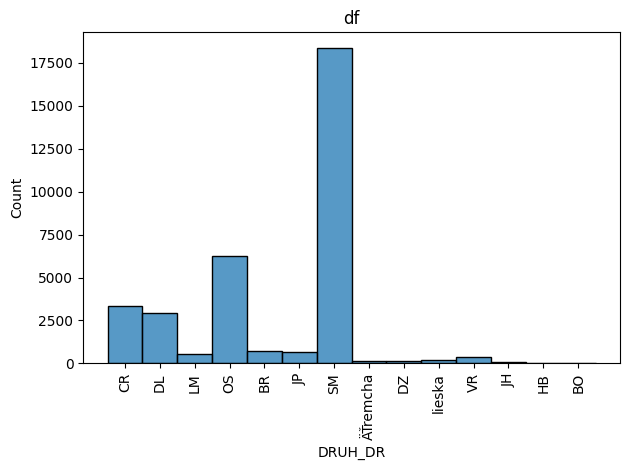

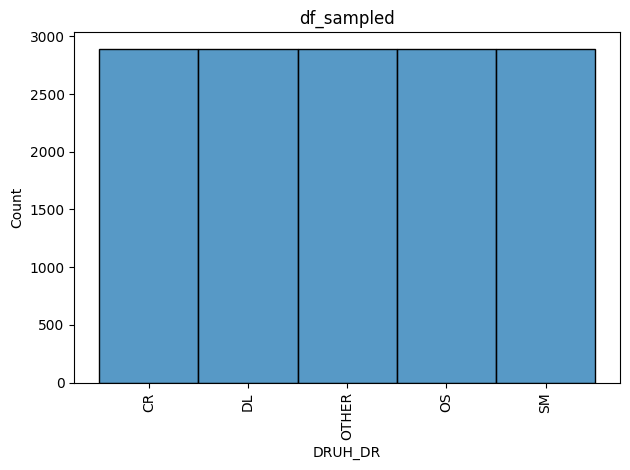

In [8]:
print_hist(df, title='df')
# plot_band_characteristics(df)

if df_sampled is not None:
    print_hist(df_sampled, title='df_sampled')
    # plot_band_characteristics(df_sampled)

In [15]:
df.describe() - df_sampled.describe()

,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,b7_12_10_2,b8_12_10_2,b9_12_10_2,b10_12_10_,...,b177_12_10,b178_12_10,b179_12_10,b180_12_10,b181_12_10,b182_12_10,b183_12_10,b184_12_10,b185_12_10,b186_12_10
count,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,...,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000
mean,-0.000332,-0.000347,-0.000373,-0.000395,-0.000413,-0.000429,-0.000429,-0.000428,-0.000403,-0.000483,...,-0.007665,-0.009466,-0.009028,-0.008787,-0.009370,-0.010165,-0.010707,-0.011011,-0.011178,-0.011341
std,-0.000013,-0.000018,-0.000023,-0.000030,-0.000031,-0.000030,-0.000027,-0.000025,-0.000020,-0.000024,...,0.000235,0.000291,0.000277,0.000270,0.000296,0.000329,0.000343,0.000357,0.000359,0.000370
min,0.000000,-0.000122,-0.000103,0.000000,-0.000016,-0.000104,-0.000035,-0.000014,0.000000,-0.000052,...,0.000000,-0.000279,-0.000235,-0.000210,-0.000130,-0.000262,-0.000081,-0.000334,-0.000097,-0.000225
25%,-0.000382,-0.000396,-0.000420,-0.000447,-0.000484,-0.000508,-0.000510,-0.000512,-0.000481,-0.000579,...,-0.009702,-0.011905,-0.011416,-0.011122,-0.011938,-0.012790,-0.013485,-0.014022,-0.014149,-0.014496
50%,-0.000343,-0.000354,-0.000384,-0.000390,-0.000413,-0.000428,-0.000431,-0.000435,-0.000418,-0.000501,...,-0.011018,-0.013564,-0.012981,-0.012602,-0.013503,-0.014676,-0.015463,-0.015874,-0.016043,-0.016334
75%,-0.000349,-0.000380,-0.000399,-0.000434,-0.000444,-0.000458,-0.000460,-0.000453,-0.000418,-0.000511,...,-0.007526,-0.009310,-0.008848,-0.008569,-0.009136,-0.010042,-0.010534,-0.010872,-0.010953,-0.011162
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## prepare data (assuming that the last column is label)

In [16]:
def split_to_train_val(df, frac=0.7, random_state=0):
    df_train = df.sample(frac=frac, axis=0, random_state=random_state)
    df_val = df[~df.index.isin(df_train.index)]
    return df_train, df_val

df_train, df_val = split_to_train_val(
    df_sampled if df_sampled is not None else df
)

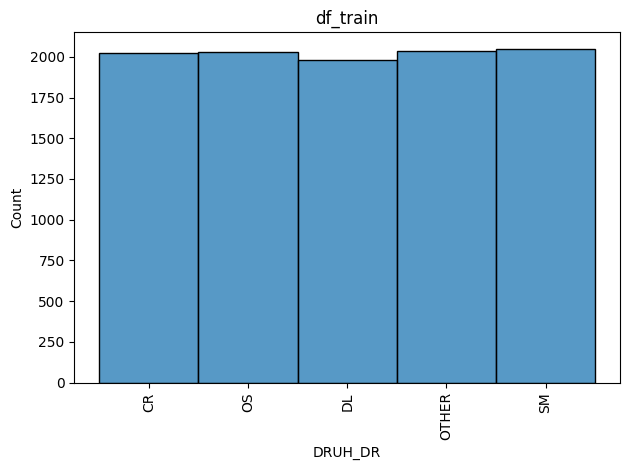

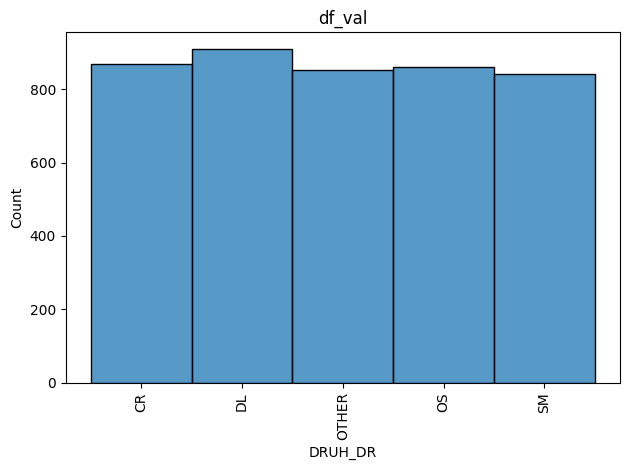

In [17]:
print_hist(df_train, title='df_train')
print_hist(df_val, title='df_val')

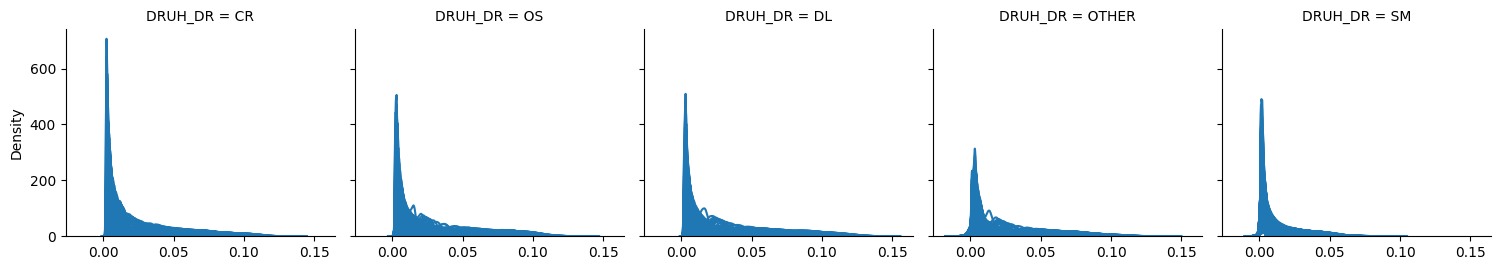

In [18]:
plot_band_characteristics(df_train)

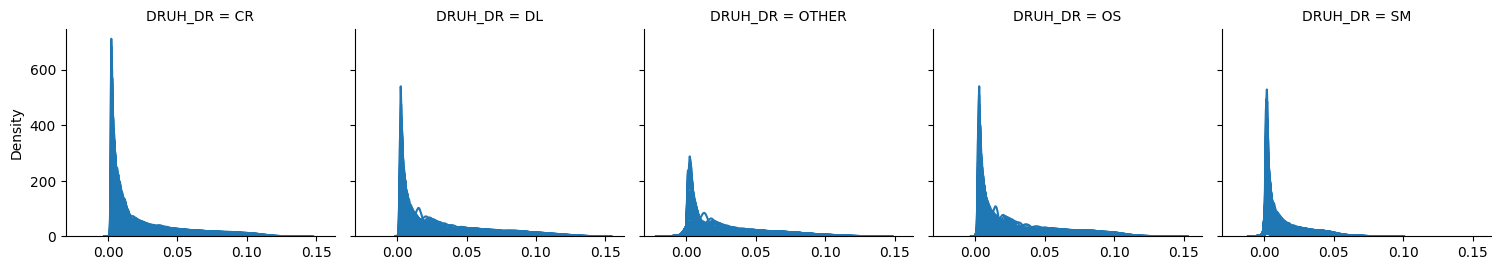

In [19]:
plot_band_characteristics(df_val)

In [20]:
X_train=df_train[df_train.columns[:-1]]
Y_train=df_train[[df_train.columns[-1]]]

num_classes = (df_sampled.DRUH_DR if df_sampled is not None else df.DRUH_DR).unique().shape[0]

label_encoder = LabelEncoder()
label_encoder.fit(
    df_sampled.DRUH_DR if df_sampled is not None else df.DRUH_DR
)

Y_train_1hot = to_categorical(
    label_encoder.transform(Y_train.DRUH_DR),
    num_classes=num_classes
)

In [21]:
X_val=df_val[df_val.columns[:-1]]
Y_val=df_val[[df_val.columns[-1]]]
Y_val_1hot = to_categorical(
    label_encoder.transform(Y_val.DRUH_DR),
    num_classes=num_classes
)

In [22]:
display(X_train)
display(Y_train)
display(Y_train_1hot)

,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,b7_12_10_2,b8_12_10_2,b9_12_10_2,b10_12_10_,...,b177_12_10,b178_12_10,b179_12_10,b180_12_10,b181_12_10,b182_12_10,b183_12_10,b184_12_10,b185_12_10,b186_12_10
3715,0.003926,0.004088,0.004291,0.004395,0.004393,0.004273,0.004438,0.004200,0.004341,0.004870,...,0.030799,0.037666,0.036690,0.034553,0.037150,0.040929,0.043040,0.046127,0.045958,0.046212
8368,0.003307,0.003464,0.003661,0.003924,0.004224,0.004509,0.004085,0.004228,0.003859,0.004752,...,0.051917,0.062998,0.060024,0.058334,0.062577,0.066016,0.067936,0.072620,0.075160,0.076100
17300,0.005368,0.006064,0.006194,0.006081,0.006395,0.006799,0.007101,0.006773,0.006125,0.007575,...,0.062940,0.075846,0.072011,0.070031,0.073768,0.080651,0.083074,0.088582,0.086810,0.088933
25208,0.001881,0.001690,0.001925,0.001946,0.002174,0.002063,0.001969,0.001956,0.001618,0.002128,...,0.018012,0.021320,0.019814,0.019785,0.021558,0.023556,0.025038,0.025378,0.025014,0.025882
3630,0.002272,0.002146,0.002656,0.002879,0.002750,0.002538,0.002730,0.002697,0.002477,0.002831,...,0.021983,0.027474,0.027435,0.024902,0.028504,0.030361,0.031316,0.032690,0.032696,0.033467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17302,0.003302,0.003931,0.003991,0.004509,0.004536,0.004770,0.004648,0.004572,0.004317,0.004966,...,0.056785,0.067055,0.064200,0.062382,0.065290,0.070559,0.078009,0.077627,0.079251,0.080451
6720,0.001748,0.001930,0.001868,0.001693,0.001870,0.001924,0.001907,0.001738,0.001550,0.001915,...,0.015724,0.019672,0.018345,0.017337,0.018807,0.019795,0.021617,0.022424,0.021880,0.022546
3631,0.002117,0.002204,0.002322,0.002688,0.002499,0.002541,0.002625,0.002682,0.002285,0.002640,...,0.024056,0.030738,0.028594,0.029152,0.029847,0.034549,0.034835,0.035494,0.035936,0.037045
9055,0.003012,0.003044,0.003527,0.003658,0.003848,0.004170,0.003696,0.003918,0.003802,0.004599,...,0.047707,0.060168,0.054732,0.055322,0.058070,0.061721,0.068016,0.070523,0.070064,0.069562


,DRUH_DR
3715,CR
8368,OS
17300,DL
25208,OS
3630,CR
...,...
17302,DL
6720,SM
3631,CR
9055,OS


array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [24]:
display(X_val)
display(Y_val)
display(Y_val_1hot)

,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,b7_12_10_2,b8_12_10_2,b9_12_10_2,b10_12_10_,...,b177_12_10,b178_12_10,b179_12_10,b180_12_10,b181_12_10,b182_12_10,b183_12_10,b184_12_10,b185_12_10,b186_12_10
12939,0.002669,0.002636,0.002950,0.003349,0.003470,0.003260,0.003232,0.003402,0.003077,0.003816,...,0.053172,0.064136,0.062661,0.060507,0.064022,0.070418,0.072805,0.074579,0.075459,0.075252
4482,0.003707,0.003856,0.004034,0.004349,0.004342,0.004585,0.004660,0.004768,0.004211,0.005256,...,0.042628,0.053336,0.051336,0.049291,0.053068,0.057639,0.060540,0.060436,0.063171,0.065448
2954,0.003419,0.003546,0.003571,0.003868,0.003850,0.003901,0.004175,0.003823,0.003685,0.003886,...,0.023701,0.028777,0.029161,0.028124,0.029573,0.030913,0.033050,0.033585,0.034366,0.035789
4994,0.004075,0.004181,0.004326,0.004476,0.004685,0.004842,0.004897,0.005013,0.004918,0.005540,...,0.041920,0.051016,0.048033,0.045699,0.050537,0.055006,0.057214,0.058009,0.059627,0.059527
36,0.001799,0.002142,0.002038,0.001865,0.002269,0.002375,0.002410,0.002062,0.002243,0.002575,...,0.029871,0.036970,0.034365,0.033574,0.036387,0.039827,0.039193,0.041596,0.041447,0.043001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7287,0.002331,0.002269,0.002569,0.002813,0.003027,0.002767,0.002870,0.003062,0.002733,0.003422,...,0.022282,0.028244,0.026433,0.025254,0.027549,0.029509,0.032363,0.032180,0.032466,0.034281
21207,0.001413,0.001292,0.001315,0.001372,0.001565,0.001360,0.001447,0.001235,0.001361,0.001503,...,0.006970,0.008055,0.007906,0.008225,0.008152,0.008906,0.009248,0.010022,0.010154,0.010284
29589,0.000781,0.000807,0.000994,0.000947,0.000812,0.000880,0.000860,0.000822,0.000910,0.000918,...,0.001722,0.002203,0.001856,0.002152,0.002360,0.001910,0.003209,0.002577,0.002932,0.003642
6228,0.002705,0.002496,0.002904,0.002860,0.002939,0.002974,0.002923,0.003005,0.002966,0.003559,...,0.022710,0.026962,0.026594,0.026847,0.027838,0.029290,0.031713,0.033709,0.030250,0.034763


,DRUH_DR
12939,CR
4482,CR
2954,CR
4994,CR
36,CR
...,...
7287,SM
21207,SM
29589,SM
6228,SM


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [25]:
def make_model(
    input_shape: tuple,
    dense1: int = 28,
    dense2: int = 28,
    activation: str = 'sigmoid',
    num_classes: int = 14
):
    featureInputLayer = tf.keras.Input(shape=input_shape)
    fullyConnectedLayer1 = tf.keras.layers.Dense(dense1, name="fullyConnectedLayer1_")(featureInputLayer)
    batchNormalizationLayer = tf.keras.layers.BatchNormalization(epsilon=0.000010, name="batchNormalizationLayer_")(fullyConnectedLayer1)
    sigmoidLayer = tf.keras.layers.Activation(activation)(batchNormalizationLayer)
    dropoutLayer = tf.keras.layers.Dropout(0.150000)(sigmoidLayer)
    fullyConnectedLayer3 = tf.keras.layers.Dense(dense2, name="fullyConnectedLayer3_")(dropoutLayer)
    sigmoidLayer2 = tf.keras.layers.Activation(activation)(fullyConnectedLayer3)
    fullyConnectedLayer4 = tf.keras.layers.Dense(num_classes, name="fullyConnectedLayer4_")(sigmoidLayer2)
    softmaxLayer = tf.keras.layers.Softmax()(fullyConnectedLayer4)
    classificationLayer = softmaxLayer

    model = tf.keras.Model(inputs=[featureInputLayer], outputs=[classificationLayer])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

In [26]:
wandb.init(project='hysped-myModel3-local')
model = make_model(
    input_shape=(X_train.shape[1], ),
    num_classes=num_classes
)
history = model.fit(
    x=X_train,
    y=Y_train_1hot,
    validation_data=(X_val, Y_val_1hot),
    epochs=50,
    shuffle=True,
    batch_size=128,
    callbacks=[
        WandbMetricsLogger(),
    ],
    verbose=1
)
wandb.finish()

Epoch 1/50
80/80 [==============================] - 3s 11ms/step - loss: 1.5013 - categorical_accuracy: 0.4339 - val_loss: 1.6044 - val_categorical_accuracy: 0.2005
Epoch 2/50
80/80 [==============================] - 1s 10ms/step - loss: 1.3339 - categorical_accuracy: 0.5808 - val_loss: 1.6029 - val_categorical_accuracy: 0.2005
Epoch 3/50
80/80 [==============================] - 1s 10ms/step - loss: 1.1771 - categorical_accuracy: 0.6478 - val_loss: 1.5894 - val_categorical_accuracy: 0.2794
Epoch 4/50
80/80 [==============================] - 1s 10ms/step - loss: 1.0285 - categorical_accuracy: 0.6916 - val_loss: 1.5634 - val_categorical_accuracy: 0.3742
Epoch 5/50
80/80 [==============================] - 1s 10ms/step - loss: 0.9100 - categorical_accuracy: 0.7197 - val_loss: 1.5220 - val_categorical_accuracy: 0.3349
Epoch 6/50
80/80 [==============================] - 1s 10ms/step - loss: 0.8149 - categorical_accuracy: 0.7465 - val_loss: 1.4206 - val_categorical_accuracy: 0.4701
Epoch 7/50

epoch/categorical_accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇██▇█▇▇█▇█▇█▇█▇██████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▂▃▄▃▆▇▇▆▇▇▇▇▇▆▇▅▇▇▅█▆▇▅█▅▇▅▇▇▆▅▇█▆█▇▆▇
epoch/val_loss,████▇▆▅▄▂▄▃▂▂▂▂▃▂▅▂▂▅▁▃▂▄▁▅▂▅▂▂▃▄▂▁▃▁▁▂▂
epoch/categorical_accuracy,0.84409
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.4447
epoch/val_categorical_accuracy,0.77647


136/136 [==============================] - 0s 3ms/step


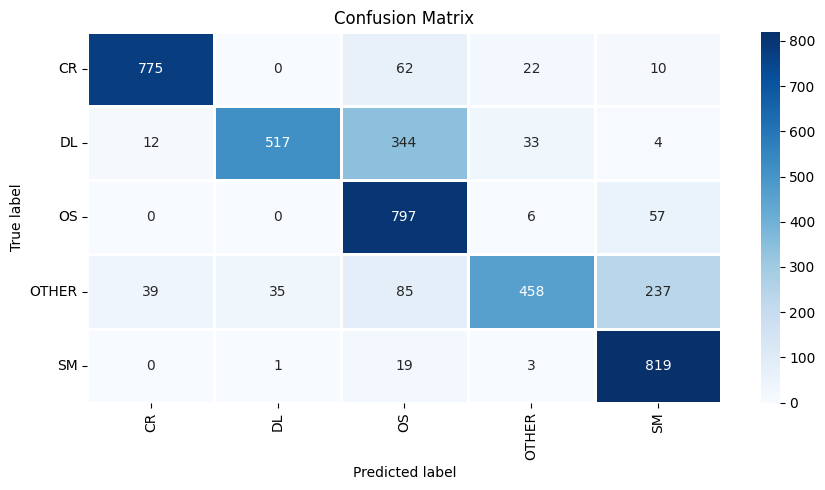

In [27]:
Y_pred = predict_model(model, X_val, Y_val, label_encoder=label_encoder)
cm = confusion_matrix(Y_val, Y_pred)

fig, ax = plt.subplots(figsize=(9,5))
print_cm(ax, cm, labels=label_encoder.classes_)
plt.show()

## hyperparameter tuning

In [ ]:
project_name = 'hysped-myModel3-sweep-proportional-data'

def main():
    wandb.init(project=project_name)
    model = make_model(
        input_shape=(X_train.shape[1], ),
        dense1=wandb.config.dense1,
        dense2=wandb.config.dense2,
        activation=wandb.config.activation,
        num_classes=num_classes
    )
    history = model.fit(
        x=X_train,
        y=Y_train_1hot,
        epochs=50,
        validation_data=(X_val, Y_val_1hot),
        shuffle=True,
        batch_size=wandb.config.batch_size,
        callbacks=[
            WandbMetricsLogger(),
        ],
        verbose=0
    )
    wandb.log(pd.DataFrame(history.history)[-1:].reset_index(drop=True).to_dict(orient='records')[0])

# Define the search space
sweep_configuration = {
    'method': 'random',
    'metric': {
        'goal': 'maximize',
        'name': 'val_categorical_accuracy'
    },
    'parameters': {
        'dense1': {
            'values': [2**x for x in range(3,6)]
        },
        'dense2': {
            'values': [2**x for x in range(3,6)]
        },
        'activation': {
            'values': ['relu', 'sigmoid']
        },
        'batch_size': {
            'values': [2**x for x in range(8)]
        }
     }
}

# Start the sweep
sweep_id = wandb.sweep(sweep=sweep_configuration, project=project_name)
wandb.agent(sweep_id, function=main, count=25)
wandb.finish()

Create sweep with ID: xucvp5uf
Sweep URL: https://wandb.ai/hysped/hysped-myModel3-sweep-proportional-data/sweeps/xucvp5uf


wandb: Agent Starting Run: otw46v5b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 8
wandb: 	dense1: 16
wandb: 	dense2: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


categorical_accuracy,▁
epoch/categorical_accuracy,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇█▇█████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▃▇▇▄▃▇▄▆▇▃▂▅▂▇▅▆▆▇▇▁▆▄▄█▆▆███▆▄▇▆▆▅▃▇▆▂▇
epoch/val_loss,█▅▄▅▆▃▄▄▃▇▇▄▇▂▄▄▃▂▂█▃▄▅▁▄▄▁▂▁▃▅▂▂▄▃▆▂▄▆▁
loss,▁
val_categorical_accuracy,▁
val_loss,▁
categorical_accuracy,0.77963


wandb: Agent Starting Run: weuox1xh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dense1: 32
wandb: 	dense2: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


categorical_accuracy,▁
epoch/categorical_accuracy,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇▇███▇████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▂▅▅▄▅▇▅▃█▅█▅▆▇▅▅▄▆▅▇▆▆▄▇█▇▆▆▇▇▇▆▇█▅▄▇▇
epoch/val_loss,▄▄▃▃▂█▃▂▃▅▁▃▁▂▂▁▃▄▇▃▃▂▃▂▆▂▁▂▂▃▂▁▂▅▁▁▄▇▁▂
loss,▁
val_categorical_accuracy,▁
val_loss,▁
categorical_accuracy,0.86614


wandb: Agent Starting Run: gzr5d25r with config:
wandb: 	activation: relu
wandb: 	batch_size: 8
wandb: 	dense1: 8
wandb: 	dense2: 8
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


categorical_accuracy,▁
epoch/categorical_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁
epoch/val_categorical_accuracy,▄▄▄▄█▅▄▅▄█▅▄▆▆▇▇▇▄▃▇▂▄▆▇▆▅▆▃▁▅▆▃██▇▇▅▅█▇
epoch/val_loss,▄▄▃▄▁▃▃▂▄▁▃▄▂▃▂▂▂▄▄▂▄▄▂▂▂▃▂██▃▂▇▁▁▁▂▃▂▁▂
loss,▁
val_categorical_accuracy,▁
val_loss,▁
categorical_accuracy,0.75195


wandb: Agent Starting Run: 3nl3xuvd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	dense1: 16
wandb: 	dense2: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


categorical_accuracy,▁
epoch/categorical_accuracy,▁▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▃▄▄▅▆▇▇▆▅▆▇▇▇▅▅▆█▆▇▇▆▇███▆█▆█▇▇█▄▇▇▅▅
epoch/val_loss,████▇▆▆▅▃▃▃▄▄▂▂▂▅▄▃▂▃▂▂▃▂▁▂▁▄▁▃▁▂▁▁▅▂▂▅▆
loss,▁
val_categorical_accuracy,▁
val_loss,▁
categorical_accuracy,0.8258


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2o8r7p6m with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dense1: 8
wandb: 	dense2: 8
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


categorical_accuracy,▁
epoch/categorical_accuracy,▁▅▆▆▇▆▇▇▇▇▇▇▇▇█▇█▇▇▇▇██████████████▇████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
epoch/val_categorical_accuracy,▁▂▅▅▇▅▃▅▄▅▅▅▂▃▇▃▅▇▅█▆▅▃█▆▇▅▄█▅▂▆▆▆▂▂▆▇▇▆
epoch/val_loss,▂▂▂▂▁▂▃▂▃▂▂▂▂▄▁▅▂▁▂▁▂▃▅▁▂▁▂▃▁▂█▂▁▂▅▅▁▁▁▁
loss,▁
val_categorical_accuracy,▁
val_loss,▁
categorical_accuracy,0.81434


wandb: Agent Starting Run: x77b71r6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 2
wandb: 	dense1: 16
wandb: 	dense2: 16
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


categorical_accuracy,▁
epoch/categorical_accuracy,▁▃▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████▇█
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁
epoch/val_categorical_accuracy,▄▂▄▄▄▁▅▃▃▅█▇▃▆▄▆▅▃▅▅▇▅▇▄▆▇▆▃▅▆▆▆▄▇▄▄▆▆▇▄
epoch/val_loss,█▇▅▅▆▇▅▆▄▄▁▂▄▃▃▂▃▆▃▃▁▄▁▅▂▁▂▅▃▂▂▂▃▁▄▃▁▁▁▄
loss,▁
val_categorical_accuracy,▁
val_loss,▁
categorical_accuracy,0.6003


wandb: Agent Starting Run: tvipmaew with config:
wandb: 	activation: relu
wandb: 	batch_size: 1
wandb: 	dense1: 32
wandb: 	dense2: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
